# Workgroup 5 - Group 7

# Bootstrapping

For this lab, we analyze the Pennsylvania re-employment bonus experiment, aiming to observe the impacts of different treatments on unemployment duration. In this case, we focus on the treatment group $T4$ (people who received a high bonus amount, had a long qualification period, and were offered a workshop). 

To observe the treatment effects, we obtain bootstrap estimates. Then we find the Standard Error associated with the estimated coefficients. For this, we first keep the subset of non-treated ($T0$) and type-4-treated individuals ($T4$). Then we define our indexing function and our estimating function. Last but not least we define the bootstrap function and we compute 1,000 estimates to find the standard error of each estimated coefficient (we focus on 3 coefficients: T4, Female, and Black).




In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

### Importing the dataset
Here we import the information, keeping the relevant treatment gruoups mentiones above.

In [5]:
# We import the dataset

Penn = pd.read_csv("data/penn_jae.dat" , sep='\s', engine='python')
#Penn = pd.read_csv("..\data" , sep='\s', engine='python')
Penn = Penn[ (Penn['tg'] == 4) | (Penn['tg'] == 0) ]

# We obtain the log-level inuidur variable
Penn['log_inuidur1'] = np.log(Penn['inuidur1'])

# We create dummies for each dep value and then recode T4 to get T4 = 1 if treated and 0 otherwise
Penn = pd.get_dummies(Penn, columns = ['dep'])
Penn['T4'] = Penn['tg']/4

### Random indexing function
Here we define a random indexing function, that ensures the process is done using sample with replacement.

In [6]:
# Our random indexing function
def get_indices(data,num_samples):
    return  np.random.choice(data.index, num_samples, replace=True)

In [37]:
indices=get_indices(Penn,1000)
indices

array([  725,  4059, 12949,  3575,   432,  7598, 11007,  8576, 11912,
        2092,  6426,  8345,  4389,  2548,  6792,  9214, 13898,  3322,
        9604,  7419,  3610, 12094,  1547,  9022,  2704,  3857,  4937,
        7239,  1955, 13147, 12828,  2185,  1667,  2171,  9742,  6977,
        3761,  6640,  9642, 11566,  3861,  5095,  9295,  9688,  5681,
        4554,  1885,  2413, 12920,  2778,   286,  5151,  7690,  4277,
        7837,  8403,   418,  2932,  9644,  3296,  5523,   565,  4238,
        5806,  8062,  4840, 12682,  9299,   721, 12102,  4795,  8532,
        7794,  6546,  1219,  1156, 10159,  4309,  8234,  3518,  8898,
        5565, 13121, 10852,  4463,  6542,  4633,  5596,  3698,  2324,
        6777,  1593,   449,  1880,  3777,  7245,  2528, 12813,  8647,
        6781,   620,  4955,  3389, 10762,  6784, 11172, 13001,  7254,
        9221,  7953,  2098,  4212,  5481,   565, 10972,  5065,  6485,
        8403, 10565,  6451,  2997,  1364,  1004,  7970,  9058, 12889,
        4753, 13846,

### Estimating Coefficients
Here we define the function that estimates the coefficients. For this we define the following linear regression:

$$
Y = \alpha_1 T4 + \alpha_2 Female +\alpha_3 Black + W'\beta + \varepsilon
$$

In this case, we are interested in observing the effects of treatment 4, whether the person is female or not, and whether the person is black in the log of the duration of unemployment. $W$ is a set of control variables.


In [12]:
# Here we define the function to obtain estimates of coefficients
# We use the Scikitlearn to estimate the linear regressions

def get_estimates(data,index):
    X = data['log_inuidur1'].loc[index]
    y =  data[['T4','female', 'black', 'othrace', 'dep_0', 'dep_1', 'dep_2', 'q2', 'q3', 'q4', 'q5', 'q6', 'agelt35', 'agegt54', 'durable', 'lusd', 'husd']].loc[index]
    
    lr = LinearRegression()
    lr.fit(X.to_frame(),y)
    
    coef_t4 = lr.coef_[0]
    coef_fem = lr.coef_[1]
    coef_black = lr.coef_[2]
    return [coef_t4,coef_fem, coef_black]




In [15]:
#modifying the boot mentioned that we used earlier
# Here we 
def boot(data,func,R):
    t4_c = []
    fem_c = []
    black_c = []
    for i in range(R):
        t4_c.append(func(data,get_indices(data,1000))[0])
        fem_c.append(func(data,get_indices(data,1000))[1]) 
        black_c.append(func(data,get_indices(data,1000))[2]) 
    t4_statistics = {'estimated_value':np.mean(t4_c),'std_error':np.std(t4_c)}   
    fem_statistics = {'estimated_value':np.mean(fem_c),'std_error':np.std(fem_c)}   
    black_statistics = {'estimated_value':np.mean(black_c),'std_error':np.std(black_c)}   
    return {'T4_coef_stats':t4_statistics,'Female_coef_stats':fem_statistics, 'Black_coef_stats': black_statistics}

In [13]:
results = boot(Penn,get_estimates,1000)

In [10]:
table = pd.DataFrame(results)
table = table.set_index(pd.Index(['Estimated Coefficient', 'Standard Error']))
table = table.rename({'T4_coef_stats': 'T4', 'Female_coef_stats': 'Female', 'Black_coef_stats':'Black'}, axis=1) 
table

,T4,Female,Black
Estimated Coefficient,-0.013096,0.018663,-0.020154
Standard Error,0.012268,0.012401,0.009602


The estimated coefficients using bootstrapping are, in all cases, almost $0$ which indicates that no there are virtually no effects of the treatment, the sex, and whether the person is black in the log duration of unemployment.


### Graphs
We also present some graphs, which show the distribution of the estimated coefficient for each variable of interest. We notice that all resemble a normal distribution, with a mean close to $0$.


In [49]:
def GRAPH(data,func,R):
    t4_c = []
    fem_c = []
    black_c = []
    for i in range(R):
        t4_c.append(func(data,get_indices(data,1000))[0])
        fem_c.append(func(data,get_indices(data,1000))[1]) 
    
    return pd.DataFrame(
     {
        "T4": t4_c,
        "fem_c": fem_c,
        "black_c": black_c,
    }
    )

C:\Anaconda\envs\renv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


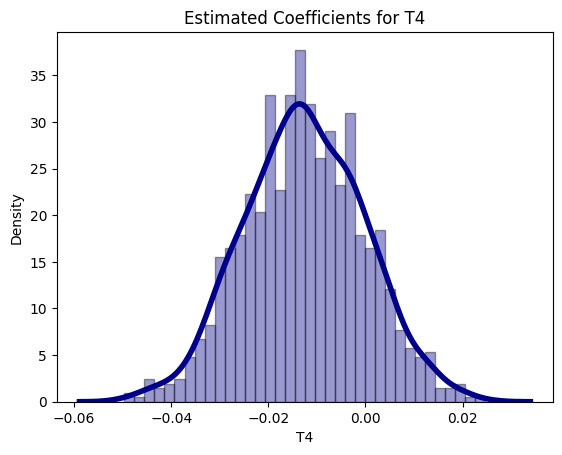

In [63]:
graph=GRAPH(Penn,get_estimates,1000)


sns.distplot(graph['T4'],hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Estimated Coefficients for T4')
plt.show()

C:\Anaconda\envs\renv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


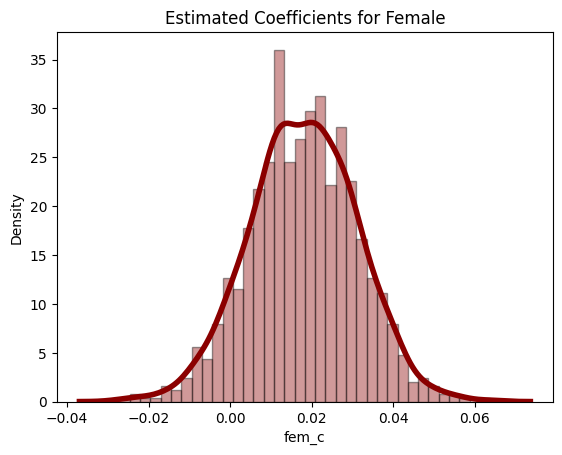

In [65]:
sns.distplot(graph['fem_c'],hist=True, kde=True, 
             bins=int(180/5), color = 'darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Estimated Coefficients for Female')
plt.show()

C:\Anaconda\envs\renv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


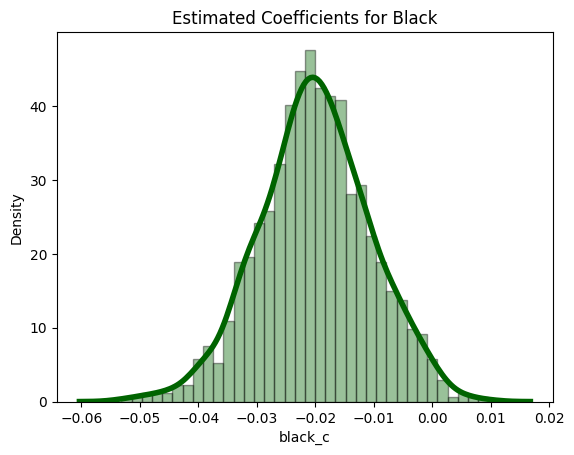

In [66]:
sns.distplot(graph['black_c'],hist=True, kde=True, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Estimated Coefficients for Black')
plt.show()